### This solution is based on [Andrej Marinchenko's work](https://www.kaggle.com/code/andrej0marinchenko/hyperparamaters)

# Import Library

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

rcParams['figure.figsize'] = (12, 9) # Figure size

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

# Importing dataset

In [2]:
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                   usecols = ['date', 'store_nbr', 'family', 'sales'])
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
train

sales
date       store_nbr family                              
2013-01-01 1         AUTOMOTIVE                     0.000
                     BABY CARE                      0.000
                     BEAUTY                         0.000
                     BEVERAGES                      0.000
                     BOOKS                          0.000
...                                                   ...
2017-08-15 9         POULTRY                      438.133
                     PREPARED FOODS               154.553
                     PRODUCE                     2419.729
                     SCHOOL AND OFFICE SUPPLIES   121.000
                     SEAFOOD                       16.000

[3000888 rows x 1 columns]

In [3]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
test

id  onpromotion
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888            0
                     BABY CARE                   3000889            0
                     BEAUTY                      3000890            2
                     BEVERAGES                   3000891           20
                     BOOKS                       3000892            0
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395            1
                     PREPARED FOODS              3029396            0
                     PRODUCE                     3029397            1
                     SCHOOL AND OFFICE SUPPLIES  3029398            9
                     SEAFOOD                     3029399            0

[28512 rows x 2 columns]

# Calendar Engineering

In [4]:
# Full date range
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)
calendar

,avg_oil
2013-01-10,93.218571
2013-01-11,93.284286
2013-01-12,93.284286
2013-01-13,93.284286
2013-01-14,93.470000
...,...
2017-08-27,47.720000
2017-08-28,47.624286
2017-08-29,47.320000
2017-08-30,47.115714


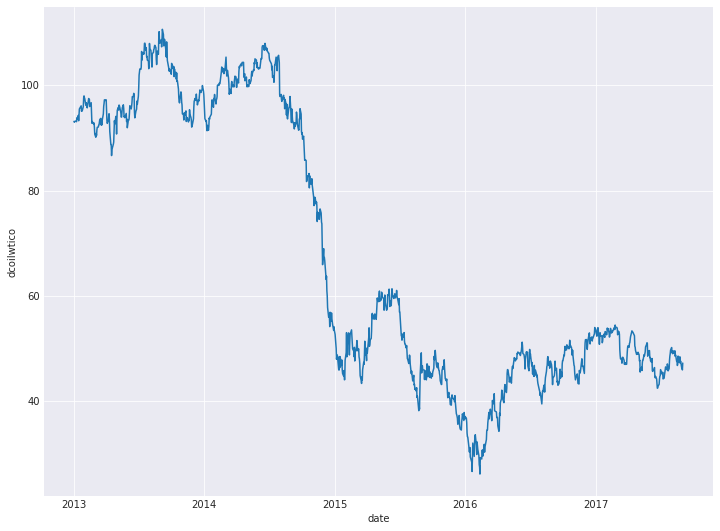

In [5]:
# Plotting oil price
_ = sns.lineplot(data = oil.dcoilwtico.to_timestamp())

You can see that oil price is only high at 2013 to 2014, however in 2015 it's starting to go down.

So, because we only predict 16 data points we will only need the training data from at least 2015

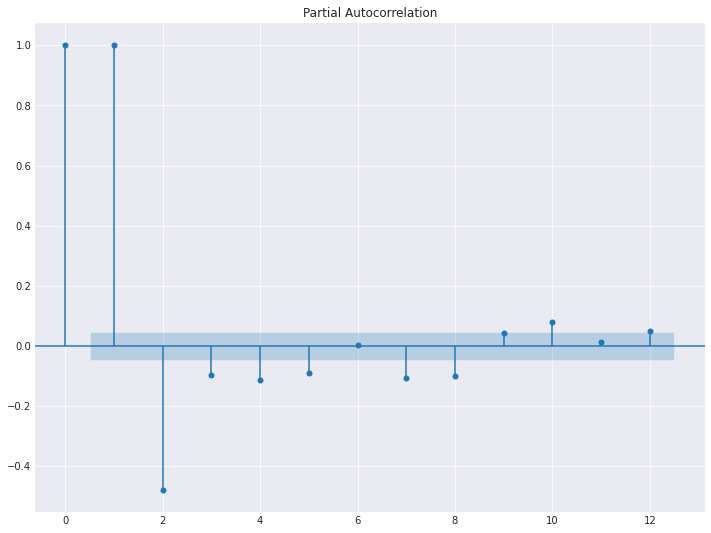

In [6]:
# Plot the partial autocorrelation function
_ = plot_pacf(calendar.avg_oil, lags = 12) # Lagplot oil price (Feature Engineering)

# Adding lags

In [7]:
# Adding lages based on the auto correlation plot

n_lags = 5
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags_{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)
calendar

,avg_oil,oil_lags_1,oil_lags_2,oil_lags_3,oil_lags_4,oil_lags_5
2013-01-15,93.490000,93.470000,93.284286,93.284286,93.284286,93.218571
2013-01-16,93.644286,93.490000,93.470000,93.284286,93.284286,93.284286
2013-01-17,93.970000,93.644286,93.490000,93.470000,93.284286,93.284286
2013-01-18,94.331429,93.970000,93.644286,93.490000,93.470000,93.284286
2013-01-19,94.331429,94.331429,93.970000,93.644286,93.490000,93.470000
...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,47.645714,47.522857
2017-08-28,47.624286,47.720000,47.720000,47.720000,47.598571,47.645714
2017-08-29,47.320000,47.624286,47.720000,47.720000,47.720000,47.598571
2017-08-30,47.115714,47.320000,47.624286,47.720000,47.720000,47.720000


# Correlation plot

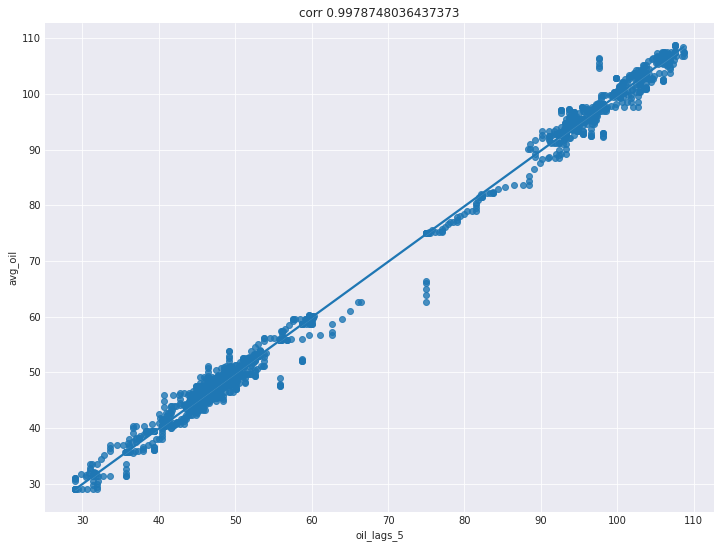

In [8]:
lag = 'oil_lags_5'
plt.figure()
sns.regplot(x = calendar[lag], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag])}')
plt.show()

# Importing holiday dataset

In [9]:
hol = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
hol = hol[hol.locale == 'National'] # I'm only taking National holiday so there's no false positive.
hol = hol.groupby(hol.index).first() # Removing duplicated holiday at the same date
hol

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


# Feature Engineering for holiday

In [10]:
calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not workday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a workday
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a workday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns
calendar

,avg_oil,oil_lags_1,oil_lags_2,oil_lags_3,oil_lags_4,oil_lags_5,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-15,93.490000,93.470000,93.284286,93.284286,93.284286,93.218571,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,93.284286,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,93.284286,93.284286,1,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-18,94.331429,93.970000,93.644286,93.490000,93.470000,93.284286,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-01-19,94.331429,94.331429,93.970000,93.644286,93.490000,93.470000,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,47.645714,47.522857,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-08-28,47.624286,47.720000,47.720000,47.720000,47.598571,47.645714,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-08-29,47.320000,47.624286,47.720000,47.720000,47.720000,47.598571,1,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-30,47.115714,47.320000,47.624286,47.720000,47.720000,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0


# Dependent Variable Visualization

In [11]:
# y = train.unstack(['store_nbr', 'family']).loc['2013':'2017']
# family = {c[2] for c in train.index}
# for f in family :
#     ax = y.loc(axis = 1)['sales', :, f].plot(legend = None)
#     ax.set_title(f)

Graphs above are the visualization of each product

In [12]:
# Start and end of training date

# sdate = '2017-04-30' 
# edate = '2017-08-15'

sdate = '2017-01-01'
edate = '2017-08-15'

In [13]:
school_season = [] # Feature for school fluctuations
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season
calendar

,avg_oil,oil_lags_1,oil_lags_2,oil_lags_3,oil_lags_4,oil_lags_5,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-15,93.490000,93.470000,93.284286,93.284286,93.284286,93.218571,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,93.284286,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,93.284286,93.284286,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-18,94.331429,93.970000,93.644286,93.490000,93.470000,93.284286,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-19,94.331429,94.331429,93.970000,93.644286,93.490000,93.470000,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,47.645714,47.522857,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2017-08-28,47.624286,47.720000,47.720000,47.720000,47.598571,47.645714,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-29,47.320000,47.624286,47.720000,47.720000,47.720000,47.598571,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-30,47.115714,47.320000,47.624286,47.720000,47.720000,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0,1


# Deterministic Process

In [14]:
y = train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq = 'W', order = 3)
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x = dp.in_sample()
x = x.join(calendar)
x

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,51.801429,51.801429,51.801429,...,0,0,1,0,0,0,1,0,0,0
2017-01-02,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,51.801429,51.801429,51.801429,...,0,0,0,0,0,0,0,1,0,0
2017-01-03,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,51.801429,51.801429,51.801429,...,0,0,0,0,0,0,0,0,0,0
2017-01-04,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,51.801429,51.801429,51.801429,...,0,0,0,0,0,0,0,0,0,0
2017-01-05,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,51.801429,51.801429,51.801429,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,223.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,49.140000,49.252857,49.345714,...,1,0,0,0,0,0,0,1,0,1
2017-08-12,224.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,49.140000,49.140000,49.252857,...,0,1,0,0,0,0,0,0,0,1
2017-08-13,225.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.140000,49.140000,49.140000,...,0,0,1,0,0,0,0,0,0,1


In [15]:
print(y.isna().sum().sum())
display(y)

0


sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0    166.81900   
2017-01-03        4.0       0.0    4.0    3081.0   2.0    519.34800   
2017-01-04        1.0       0.0    4.0    3039.0   2.0    543.25100   
2017-01-05        2.0       0.0    3.0    2617.0   0.0    533.48000   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

                                                  ...                     \
store_nbr                                         ...         9            
family     CELEBRATION CLEANING   DAIRY     DELI  ... MAGAZINES    MEATS   
date                                              ...                      
2017-01-01         0.0      0.0     0.0    0.000  ...       0.0    0.000   
2017-01-02         0.0    332.0   376.0   44.980  ...       5.0  659.570   
2017-01-03        15.0    952.0  1045.0  209.300  ...       2.0  547.364   
2017-01-04        17.0   1055.0  1029.0  135.944  ...       3.0  395.288   
2017-01-05        40.0    918.0   853.0  137.006  ...       2.0  470.768   
...                ...      ...     ...      ...  ...       ...      ...   
2017-08-11         4.0    341.0   343.0   64.302  ...       5.0  309.245   
2017-08-12         3.0    351.0   526.0   99.488  ...       2.0  260.298   
2017-08-13         1.0    169.0   266.0   47.770  ...       3.0  327.206   
2017-08-14         4.0    571.0   699.0  154.578  ...      12.0  330.975   
2017-08-15        21.0    703.0   602.0  116.402  ...      11.0  449.228   

                                                                        \
store_nbr                                                                
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS  POULTRY   
date                                                                     
2017-01-01           0.0          0.0                     0.0    0.000   
2017-01-02        1243.0         11.0                    41.0  843.596   
2017-01-03         876.0          6.0                    15.0  714.660   
2017-01-04         677.0          6.0                    13.0  536.830   
2017-01-05         604.0          7.0                    10.0  414.100   
...                  ...          ...                     ...      ...   
2017-08-11         373.0         11.0                     2.0  525.224   
2017-08-12         400.0          7.0                    10.0  383.387   
2017-08-13         510.0          2.0                     9.0  412.458   
2017-08-14         445.0          2.0                    14.0  283.429   
2017-08-15         522.0          6.0                     6.0  438.133   

                                                                           
store_nbr                                                                  
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                       
2017-01-01       0.000000     0.000                        0.0   0.000000  
2017-01-02     115.188995  3136.896                        1.0  23.000000  
2017-01-03     133.039000  3229.558                        1.0  14.000000  
2017-01-04      75.201004  1491.417                        7.0   0.000000  
2017-01-05     113.699000  1566.821                        1.0  17.000000  
...           

In [16]:
xtest = dp.out_of_sample(steps = 16) # 16 because we are predicting next 16 days
xtest = xtest.join(calendar)
xtest

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags_1,oil_lags_2,...,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2017-08-16,228.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,48.648571,48.934286,...,0,0,0,0,0,0,0,0,0,1
2017-08-17,229.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,48.281429,48.648571,...,0,0,0,0,0,0,0,0,0,1
2017-08-18,230.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,47.995714,48.281429,...,1,0,0,0,0,0,0,0,0,1
2017-08-19,231.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.852857,47.852857,47.995714,...,0,1,0,0,0,0,0,0,0,1
2017-08-20,232.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.852857,47.852857,47.852857,...,0,0,1,0,0,0,0,0,0,1
2017-08-21,233.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,47.688571,47.852857,47.852857,...,0,0,0,0,0,0,0,0,0,1
2017-08-22,234.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,47.522857,47.688571,47.852857,...,0,0,0,0,0,0,0,0,0,1
2017-08-23,235.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,47.645714,47.522857,47.688571,...,0,0,0,0,0,0,0,0,0,1
2017-08-24,236.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.598571,47.645714,47.522857,...,0,0,0,0,0,0,0,0,0,1
2017-08-25,237.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.720000,47.598571,47.645714,...,1,0,0,0,0,0,0,0,0,1


In [17]:
def make_lags(x, lags = 1) :
    lags = lags
    x_ = x.copy()
    for i in range(lags) :
        lag = x_.shift(i + 1)
        x = pd.concat([x, lag], axis = 1)
    return x

# Using LinearRegression to make a generalized line (blending)

In [18]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

lnr = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)
lnr.fit(x, y)

yfit_lnr = pd.DataFrame(lnr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

svr = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
svr.fit(x, y)

yfit_svr = pd.DataFrame(svr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_svr = pd.DataFrame(svr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

yfit_mean = pd.DataFrame(np.mean([yfit_svr.values, yfit_lnr.values], axis = 0), index = x.index, columns = y.columns).clip(0.)
ypred_mean = pd.DataFrame(np.mean([ypred_lnr.values, ypred_svr.values], axis = 0), index = xtest.index, columns = y.columns).clip(0.)

y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

# print('='*70, 'Linear Regression', '='*70)
# print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['lnr']))))
print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
# print('='*70, 'SVR', '='*70)
# print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['svr']))))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
# print('='*70, 'Mean', '='*70)
# print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['mean']))))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)))

LNR RMSLE : 0.5771823958690603
SVR RMSLE : 0.688373051155324
Mean RMSLE : 0.6274893799109057


In [19]:
from sklearn.metrics import mean_absolute_error as mae

# print('='*70, 'Linear Regression', '='*70)
# print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['lnr'])))
print('LNR MAE :', mae(y, yfit_lnr))
# print('='*70, 'SVR', '='*70)
# print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['svr'])))
print('SVR MAE :', mae(y, yfit_svr))
# print('='*70, 'Mean', '='*70)
# print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['mean'])))
print('Mean MAE :', mae(y, yfit_mean))

LNR MAE : 65.89359275838207
SVR MAE : 114.5653260899869
Mean MAE : 80.95488979398024


As you can see, with RMSLE, the best model is the averaging of linear regression and SVR.

But, in MAE, Linear Regression has the least loss than Mean. What does it mean?

Because in RMSLE we are applying log, that means higher the value, the lower the deviation.

Let me show you

In [20]:
true_low = [2]
pred_low = [4]

print('RMSLE for low value :', round(np.sqrt(msle(true_low, pred_low)),1))
print('MAE for low value :', mae(true_low, pred_low))

true_high = [255]
pred_high = [269]

print('RMSLE for high value :', round(np.sqrt(msle(true_high, pred_high)),1))
print('MAE for high value :', mae(true_high, pred_high))

RMSLE for low value : 0.5
MAE for low value : 2.0
RMSLE for high value : 0.1
MAE for high value : 14.0


As you can see, RMSLE will have higher "tolerance" for higher value meanwhile Mean Absolute Error will go as usual.

Therefore, I will take the Linear Regression's result instead because it has lower MAE and MAE is reliable because it's robust to outlier

I'm not gonna use validation data because the data we have is not much and because we are using linear-based algorithm so only using training would be fine.

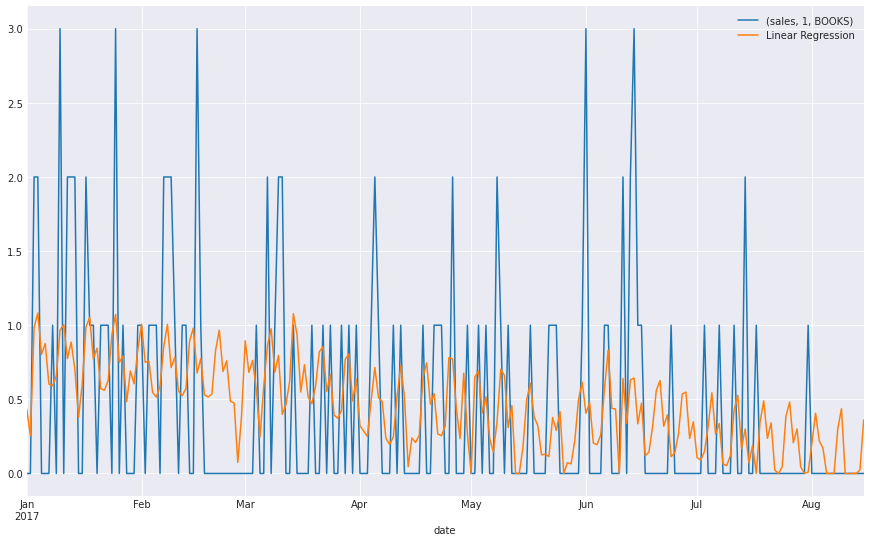

In [21]:
fam = 'BOOKS'
nbr = '1'
plt.rcParams['figure.figsize'] = (15, 9)
plt.figure()
y.loc(axis = 1)['sales', nbr, fam].plot()
yfit_lnr.loc(axis = 1)['sales', nbr, fam].plot(label = 'Linear Regression')
#yfit_svr.loc(axis = 1)['sales', nbr, fam].plot(label = 'SVR')
#yfit_mean.loc(axis = 1)['sales', nbr, fam].plot(label = 'Mean')
#y.mean(axis = 1).plot()
#yfit_lnr.median(axis = 1).plot(label = 'Linear Regression')
#yfit_svr.median(axis = 1).plot(label = 'SVR')
#yfit_mean.mean(axis = 1).plot(label = 'Mean')
plt.legend()
plt.show()

You can concat linear regression's prediction with the training data, this is called blending.

In [22]:
ymean = yfit_lnr.append(ypred_lnr)
school = ymean.loc(axis = 1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES']
ymean = ymean.join(school.shift(1), rsuffix = 'lag1') # I'm also adding school lag for its yearly cycle.
# x = x.loc['2017-05-01':]
x = x.loc['2017-01-02':]

In [23]:
x.isnull().sum().sum()

0

In [24]:
x = x.join(ymean) # Concating linear result
xtest = xtest.join(ymean)

In [25]:
# y = y.loc['2017-05-01':]
y = y.loc['2017-01-02':]
y.isnull().sum().sum()

0

This is the model I use, as I said I'm taking it from [BIZEN](https://www.kaggle.com/hiro5299834) and modifying it.

# Model Creation

In [26]:
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# SEED for reproducible result
SEED = 5

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': # Because SCHOOL AND OFFICE SUPPLIES has weird trend, we use decision tree instead.
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)]) # Averaging the result
        else:
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=SEED)
            svr = SVR(C = 0.2, kernel = 'rbf')
            
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        
        
        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

In [27]:
%%time

model = CustomRegressor(n_jobs=-1, verbose=1)
model.fit(x, y)
y_pred = pd.DataFrame(model.predict(x), index=x.index, columns=y.columns)

Fit Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

CPU times: user 3min 6s, sys: 22.8 s, total: 3min 28s
Wall time: 1h 25min 27s


In [28]:
display(y_pred)
print(y_pred.isna().sum().sum())

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-01-02   2.489937       0.0  1.210483  1837.193500  0.097282   303.433024   
2017-01-03   3.196211       0.0  3.432889  2444.348214  0.681890   403.857420   
2017-01-04   3.387002       0.0  3.467332  2530.600624  0.623651   446.322784   
2017-01-05   3.562248       0.0  3.215895  2357.270094  0.484487   418.785529   
2017-01-06   4.276112       0.0  3.232344  2510.660937  0.499041   429.876224   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   2.857809       0.0  1.467227  1743.354830 -0.068822   266.286903   
2017-08-12   3.995995       0.0  2.940672  2270.488770  0.104954   357.413229   
2017-08-13   2.669291       0.0  2.243021  1630.144634  0.023041   256.774086   
2017-08-14   3.990484       0.0  3.617494  2278.974894  0.053715   376.561412   
2017-08-15   3.941684       0.0  3.723198  2267.890046  0.209765   362.080191   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-01-02    5.337365  513.735253  594.236698   97.844296  ...  4.242181   
2017-01-03   13.343598  749.129893  795.990071  143.524027  ...  2.183930   
2017-01-04   14.667018  810.965274  871.025570  144.561339  ...  2.713847   
2017-01-05   17.158884  726.408522  793.978475  133.457928  ...  2.476770   
2017-01-06   18.100924  762.888840  849.274792  163.180163  ...  2.663604   
...                ...         ...         ...         ...  ...       ...   
2017-08-11    8.422442  507.244808  545.483511  101.412484  ...  4.553452   
2017-08-12   10.484711  595.116202  716.864943  130.131540  ...  3.471659   
2017-08-13    6.753865  442.387276  518.268733   94.679980  ...  4.874501   
2017-08-14   13.926316  665.704368  727.538527  138.777658  ...  3.413370   
2017-08-15   14.977281  707.477992  709.640433  132.566666  ...  3.370633   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-02  474.076648    688.137410     9.821034               19.571886   
2017-01-03  393.210108    480.770963     5.994353               10.522938   
2017-01-04  376.393737    456.005475     7.278154               10.798825   
2017-01-05  472.389571    449.623969     6.352008               10.575099   
2017-01-06  359.881132    423.419722     6.907677               10.090042   
...                ...           ...          ...                     ...   
2017-08-11  388.761756    497.532794     9.404323               11.361563   
2017-08-12  386.777920    514.683216     8.559629               11.038695   
2017-08-13  401.401814    535.683145     9.282690               12.875274   
2017-08-14  360.576734    442.469376     6.622559                8.847504   
2017-08-15  351.506564    426.606520     6.078025                8.162028   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-02  559.241415     135.054053  2071.769816                   5.914444   
2017-01-03  444.210509     118.194654  2057.237488                   2.192222   
20

0


# Evaluation

In [29]:
from sklearn.metrics import mean_squared_log_error
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_ = y.stack(['store_nbr', 'family']).clip(0.)

y_['pred'] = y_pred.values
print(y_.groupby('family').apply(lambda r : np.sqrt(np.sqrt(mean_squared_log_error(r['sales'], r['pred'])))))
# Looking at error
print('RMSLE : ', np.sqrt(np.sqrt(msle(y_['sales'], y_['pred']))))

family
AUTOMOTIVE                    0.707270
BABY CARE                     0.516047
BEAUTY                        0.706685
BEVERAGES                     0.854209
BOOKS                         0.467031
BREAD/BAKERY                  0.753159
CELEBRATION                   0.733246
CLEANING                      0.812407
DAIRY                         0.775571
DELI                          0.708053
EGGS                          0.713972
FROZEN FOODS                  0.725936
GROCERY I                     0.869497
GROCERY II                    0.771580
HARDWARE                      0.705666
HOME AND KITCHEN I            0.738882
HOME AND KITCHEN II           0.694424
HOME APPLIANCES               0.615191
HOME CARE                     0.714844
LADIESWEAR                    0.687519
LAWN AND GARDEN               0.714997
LINGERIE                      0.772919
LIQUOR,WINE,BEER              0.928570
MAGAZINES                     0.703626
MEATS                         0.732390
PERSONAL CARE     

All seems good.

In [30]:
y_pred.isna().sum()

sales    0
dtype: int64

In [31]:
ypred = pd.DataFrame(model.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)
ypred

Predict Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
2017-08-16   3.912088       0.0  3.765780  2327.892972  0.234494   390.946099   
2017-08-17   3.995270       0.0  3.583255  2142.365355  0.052979   365.797323   
2017-08-18   4.892907       0.0  3.477467  2314.506637  0.132002   381.141621   
2017-08-19   4.265670       0.0  3.347534  2321.881689  0.014564   378.182404   
2017-08-20   2.677641       0.0  2.353478  1632.872290  0.039058   259.320828   
2017-08-21   4.030125       0.0  3.755647  2281.439507  0.065794   377.908783   
2017-08-22   4.005685       0.0  3.809864  2273.689798  0.192311   363.514867   
2017-08-23   4.081035       0.0  3.804719  2337.007452  0.202348   394.179181   
2017-08-24   4.150095       0.0  3.564234  2158.704411  0.034339   367.003640   
2017-08-25   5.146307       0.0  3.436319  2321.412882  0.108331   379.297275   
2017-08-26   4.411593       0.0  3.422166  2328.961388  0.005742   373.836367   
2017-08-27   2.727183       0.0  2.304404  1634.137075  0.000000   254.837856   
2017-08-28   4.077460       0.0  3.748151  2283.747437  0.044991   375.286311   
2017-08-29   3.951422       0.0  3.761760  2274.056368  0.150390   361.410188   
2017-08-30   3.944687       0.0  3.830480  2331.687143  0.207865   390.922364   
2017-08-31   4.123124       0.0  3.712443  2147.508324  0.020506   365.698711   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
2017-08-16   14.740312  750.317155  774.867936  134.361744  ...  3.412519   
2017-08-17   16.921737  672.369597  704.435660  122.459815  ...  3.348568   
2017-08-18   18.484829  713.895828  766.315696  152.229419  ...  3.568450   
2017-08-19   12.656383  640.225266  745.492823  134.336268  ...  4.287368   
2017-08-20    7.196466  446.963566  523.471289   94.925851  ...  4.937122   
2017-08-21   14.288625  670.565235  731.397092  138.464219  ...  3.384269   
2017-08-22   15.119247  711.200640  713.076211  132.589208  ...  3.294960   
2017-08-23   14.455862  753.283045  782.125913  135.738581  ...  3.279649   
2017-08-24   16.406758  673.790345  708.619353  124.330491  ...  3.316914   
2017-08-25   18.174649  713.274775  761.981183  152.672227  ...  3.363389   
2017-08-26   12.098358  639.893043  740.570821  133.835999  ...  4.104795   
2017-08-27    6.866660  445.866156  515.378569   94.183254  ...  4.606735   
2017-08-28   13.789892  670.807332  728.296004  138.400002  ...  3.313623   
2017-08-29   14.912610  709.397133  707.771469  132.604199  ...  3.260517   
2017-08-30   14.689305  755.536733  775.434017  134.887200  ...  3.300804   
2017-08-31   16.526873  673.729683  706.179572  122.783812  ...  3.286809   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
2017-08-16  340.149919    401.209616     6.964965                8.099491   
2017-08-17  437.707807    392.759684     5.966437                7.815723   
2017-08-18  326.545786    366.610494     6.440053                7.207581   
2017-08-19  389.612725    513.062953     8.837336               11.932836   
2017-08-20  404.045277    536.357050     9.302384               12.776745   
2017-08-21  363.845852    445.195925     6.749958                8.814651   
2017-08-22  353.566135    428.660558     6.208923                8.194310   
2017-08-23  342.072605    404.619503     7.096785                8.324685   
2017-08-24  437.927583    401.326813     6.255843                8.052918   
2017-08-25  329.250928    377.399654     6.662804                7.348273   
2017-08-26 

In [32]:
ypred = ypred.stack(['store_nbr', 'family'])
ypred

sales
           store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     3.912088
                     BABY CARE                      0.000000
                     BEAUTY                         3.765780
                     BEVERAGES                   2327.892972
                     BOOKS                          0.234494
...                                                      ...
2017-08-31 9         POULTRY                      368.106494
                     PREPARED FOODS               107.219811
                     PRODUCE                     1342.357069
                     SCHOOL AND OFFICE SUPPLIES   128.325333
                     SEAFOOD                       15.210140

[28512 rows x 1 columns]

# Submission

In [33]:
sub = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')
sub['sales'] = ypred.values
sub.to_csv('submission.csv', index = False) # Submit
sub

,id,sales
0,3000888,3.912088
1,3000889,0.000000
2,3000890,3.765780
3,3000891,2327.892972
4,3000892,0.234494
...,...,...
28507,3029395,368.106494
28508,3029396,107.219811
28509,3029397,1342.357069
28510,3029398,128.325333
